# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


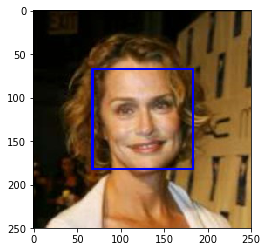

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [179]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
true_pos = sum([face_detector(path) for path in human_files_short])
false_pos = sum([face_detector(path) for path in dog_files_short])

In [7]:
print('True positives out of 100 human faces = ', true_pos) # Q1 answers
print('False positives out of 100 dog faces = ', false_pos)

True positives out of 100 human faces =  98
False positives out of 100 dog faces =  11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ It wasn't very hard to train a CNN on the LFW set so that it recognizes a test subset of the LFW as containing human faces with almost 100% accuracy, but to get one to recognize a greater variety of poses, angles, and hidden faces seems a lot harder.  Maybe this could be done by using different augmentation pre-processing parameters that I didn't try, such as shear angle and large width and height shifts that partially move the faces out of the image.  Also, perhaps training additionally on a different dataset would help. Probably the app with the Haar Cascade algorithm would be quickly abandoned by the user who couldn't get it to detect a human.

===================================================================================================================

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

In [15]:
# Make one big set of dogs and humans, in grayscale, in 250x250x1 arrays, label and shuffle them up to train a CNN
# This post suggests a better way to read directly to grayscale:
#        https://stackoverflow.com/questions/30506126/open-cv-error-215-scn-3-scn-4-in-function-cvtcolor
def graySquares(picFileList, size):
    pics = [cv2.imread(picFile) for picFile in picFileList]
    grayPics = [cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY) for pic in pics]
    resizedGrays = [cv2.resize(grayPic, (size, size)) for grayPic in grayPics]
    resizedGrays = np.array(resizedGrays) / 255.0
    resizedGrays = [np.expand_dims(pic, axis=2) for pic in resizedGrays]
    return resizedGrays

In [97]:
## this utility takes an image path and desired square size and converts it to a grayscale square tensor for keras
#  It uses the '0' flag in the imread function of cv2, as suggested in the link provided in above cell
def graySquare(imagePath, size):
    graypic = cv2.imread(imagePath, 0)
    graysq = cv2.resize(graypic, (250, 250))
    graysq = np.array(graysq) / 255.0
    # add first and fourth dims for keras models
    graysq = np.expand_dims(graysq, axis=2)
    graysq = np.expand_dims(graysq, axis=0)
    return graysq

In [60]:
##   ****TAKES 15-30 minutes to execute this cell on laptop CPU******
#    Deprecation warning won't appear again, since numpy expansion axis was changed from 3 to 2
people = graySquares(human_files, 250)
hounds1 = graySquares(train_files, 250)
hounds2 = graySquares(test_files, 250)
hounds3 = graySquares(valid_files, 250)

/Applications/anaconda/envs/aind-dog/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [61]:
# zip the pics with their one-hot-encoded target and shuffle them up
p = list(zip(people, np_utils.to_categorical(np.ones(len(people)), 2)))
h1 = list(zip(hounds1, np_utils.to_categorical(np.zeros(len(hounds1)), 2)))
h2 = list(zip(hounds2, np_utils.to_categorical(np.zeros(len(hounds2)), 2)))
h3 = list(zip(hounds3, np_utils.to_categorical(np.zeros(len(hounds3)), 2)))
mixed = p + h1 + h2 + h3
random.shuffle(mixed)

In [62]:
len(mixed)

21584

In [63]:
training = mixed[:16000]
testing = mixed[16000:]

In [64]:
# build and train a CNN        ## forgot to use dropouts
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(250, 250, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 250, 250, 16)      80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          18496     
__________

In [65]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adadelta', 
              metrics=['accuracy'])

In [66]:
X_train = np.array([pic[0] for pic in training])
y_train = np.array([pic[1] for pic in training])
X_test = np.array([pic[0] for pic in testing])
y_test = np.array([pic[1] for pic in testing])

In [67]:
X_train.shape

(16000, 250, 250, 1)

In [128]:
from keras.callbacks import ModelCheckpoint   

# train the model-- takes a long time on the CPU, but should've used dropouts and half the epochs at most
checkpointer = ModelCheckpoint(filepath='face.model.best.hdf5', 
                               verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=64, epochs=24,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 12800 samples, validate on 3200 samples
Epoch 1/24
12800/12800 [==============================] - 1018s - loss: 0.3657 - acc: 0.8258 - val_loss: 0.1254 - val_acc: 0.9559
Epoch 2/24
12800/12800 [==============================] - 911s - loss: 0.1157 - acc: 0.9545 - val_loss: 0.0626 - val_acc: 0.9784
Epoch 3/24
12800/12800 [==============================] - 908s - loss: 0.0586 - acc: 0.9777 - val_loss: 0.0382 - val_acc: 0.9862
Epoch 4/24
12800/12800 [==============================] - 847s - loss: 0.0347 - acc: 0.9870 - val_loss: 0.0252 - val_acc: 0.9909
Epoch 5/24
12800/12800 [==============================] - 831s - loss: 0.0196 - acc: 0.9944 - val_loss: 0.0197 - val_acc: 0.9928
Epoch 6/24
12800/12800 [==============================] - 833s - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0182 - val_acc: 0.9941
Epoch 7/24
12800/12800 [==============================] - 840s - loss: 0.0086 - acc: 0.9974 - val_loss: 0.0221 - val_acc: 0.9909
Epoch 8/24
12800/12800 [=======================

In [68]:
model.load_weights('face.model.best.hdf5')

In [69]:
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.998209169054


In [131]:
model.save('facefinder.h5')

In [14]:
## Re-load the model to save a lot of time

from keras.models import load_model

facefinder = load_model('facefinder.h5')

## Test the short lists of humans and dogs

In [ ]:
humans = graySquares(human_files_short, 250)
canines = graySquares(dog_files_short, 250)

humans = np.array(humans)
canines = np.array(canines)

In [17]:
preds1 = facefinder.predict_classes(humans)
preds2 = facefinder.predict_classes(canines)

 96/100 [===========================>..] - ETA: 0s

In [18]:
print('True positives out of 100 human test pics = ', sum(preds1))
print('False positives out of 100 canine test pics = ', sum(preds2))

True positives out of 100 human test pics =  100
False positives out of 100 canine test pics =  0


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [23]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [19]:
from keras.preprocessing import image                  
from tqdm import tqdm

In [20]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [21]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [22]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [24]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

trueDogs = [dog_detector(path) for path in dog_files_short]
falseDogs = [dog_detector(path) for path in human_files_short]

In [25]:
print('true positives = ', sum(trueDogs))
print('false positives = ', sum(falseDogs))


true positives =  100
false positives =  1


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [26]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:27<00:00, 30.16it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ It doesn't seem like we're looking for perfect accuracy here, so I'm not going to spend the time to augment photos.  The mix of convolutional layers and max pooling layers we used in the CIFAR-10 exercise seemed pretty effective at discovering features somewhat quickly, so I'll use that architecture as a starting point. My laptop CPU was able to get through one test epoch with parameters in the low six figures in 5-6 minutes, by using few enough and large enough filters, with strides=2 towards the end, so that I could use a few convolutional hidden layers, plus a fully connected layer at the end (with some dropouts), and still finish fitting 14 epochs while away from the computer for an hour. I used ReLU activation on the input and hidden layers, because that has worked best in all exercises thus far.  Also, adadelta optimized better than rmsprop for me in the CIFAR and Student Admissions mini-projects, so I used that here.  The results were still improving after 14 epochs, but that was the time budget that I had allocated, considering we're just looking for an idea of what can be done with this methodology, and this isn't going to be the architecture we use for the recognizer anyway. If I wanted a few more percentage points of accuracy, beyond the approx. 10% scored here, I'd now re-compile the model with its current weights and maybe a different optimizer, and run it for a few more epochs.

In [27]:
train_tensors.shape

(6680, 224, 224, 3)

In [28]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
# Start by using something similar to what worked well in CIFAR-10 without augmenting, in order to save time:

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=12, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=24, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=48, kernel_size=4, strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 12)      156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 12)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 12)      1308      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 24)        2616      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 24)        0         
__________

### Compile the Model

In [29]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [30]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 14

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/14
6680/6680 [==============================] - 344s - loss: 4.8844 - acc: 0.0100 - val_loss: 4.8729 - val_acc: 0.0120
Epoch 2/14
6680/6680 [==============================] - 304s - loss: 4.8582 - acc: 0.0126 - val_loss: 4.8203 - val_acc: 0.0192
Epoch 3/14
6680/6680 [==============================] - 315s - loss: 4.7807 - acc: 0.0228 - val_loss: 4.6865 - val_acc: 0.0299
Epoch 4/14
6680/6680 [==============================] - 318s - loss: 4.6701 - acc: 0.0262 - val_loss: 4.6023 - val_acc: 0.0407
Epoch 5/14
6680/6680 [==============================] - 297s - loss: 4.5700 - acc: 0.0376 - val_loss: 4.5033 - val_acc: 0.0395
Epoch 6/14
6680/6680 [==============================] - 309s - loss: 4.4933 - acc: 0.0403 - val_loss: 4.4485 - val_acc: 0.0467
Epoch 7/14
6680/6680 [==============================] - 313s - loss: 4.4021 - acc: 0.0493 - val_loss: 4.3566 - val_acc: 0.0503
Epoch 8/14
6680/6680 [==============================] - 307s - l

### Load the Model with the Best Validation Loss

In [31]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [32]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.8086%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [77]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [78]:
train_VGG16.shape

(6680, 7, 7, 512)

In [79]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [80]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
## Changed optimizer from rmsprop to adadelta to get a higher baseline accuracy for future comparison,
##   Then re-ran again with SGD to raise the bar a little more

### Train the Model

In [81]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=30, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 5s - loss: 12.9083 - acc: 0.0379 - val_loss: 11.1437 - val_acc: 0.0671
Epoch 2/30
6680/6680 [==============================] - 2s - loss: 9.9982 - acc: 0.1190 - val_loss: 8.9105 - val_acc: 0.1617
Epoch 3/30
6680/6680 [==============================] - 1s - loss: 8.0373 - acc: 0.2217 - val_loss: 7.4690 - val_acc: 0.2287
Epoch 4/30
6680/6680 [==============================] - 1s - loss: 6.6851 - acc: 0.3096 - val_loss: 6.4437 - val_acc: 0.2970
Epoch 5/30
6680/6680 [==============================] - 1s - loss: 5.6746 - acc: 0.3808 - val_loss: 5.7171 - val_acc: 0.3653
Epoch 6/30
6680/6680 [==============================] - 1s - loss: 4.9484 - acc: 0.4469 - val_loss: 5.1257 - val_acc: 0.4144
Epoch 7/30
6680/6680 [==============================] - 3s - loss: 4.3784 - acc: 0.5094 - val_loss: 4.7518 - val_acc: 0.4419
Epoch 8/30
6680/6680 [==============================] - 2s - loss: 3.9768 - 

In [82]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [83]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=30, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 4s - loss: 2.1815 - acc: 0.8129 - val_loss: 3.4544 - val_acc: 0.6144
Epoch 2/30
6680/6680 [==============================] - 1s - loss: 2.1589 - acc: 0.8189 - val_loss: 3.5612 - val_acc: 0.5916
Epoch 3/30
6680/6680 [==============================] - 1s - loss: 2.0492 - acc: 0.8278 - val_loss: 3.2560 - val_acc: 0.6287
Epoch 4/30
6680/6680 [==============================] - 1s - loss: 1.8332 - acc: 0.8606 - val_loss: 2.9657 - val_acc: 0.6551
Epoch 5/30
6680/6680 [==============================] - 1s - loss: 1.8094 - acc: 0.8675 - val_loss: 2.9784 - val_acc: 0.6623
Epoch 6/30
6680/6680 [==============================] - 1s - loss: 1.7080 - acc: 0.8810 - val_loss: 3.0288 - val_acc: 0.6611
Epoch 7/30
6680/6680 [==============================] - 1s - loss: 1.6634 - acc: 0.8829 - val_loss: 2.9485 - val_acc: 0.6611
Epoch 8/30
6680/6680 [==============================] - 1s - loss: 1.6460 - ac

### Load the Model with the Best Validation Loss

In [84]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [85]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
#    To get a better baseline for comparison, this accuracy ups the batch size and epochs from 20 to 30
#        and optimizes with adadelta and then SGD, instead of rmsprop
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 69.6172%


### Predict Dog Breed with the Model

In [86]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [87]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [88]:
print(train_VGG19.shape)
print(test_VGG19.shape)
print(valid_VGG19.shape)

(6680, 7, 7, 512)
(836, 7, 7, 512)
(835, 7, 7, 512)


In [89]:
### TODO: Define your architecture.

VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dropout(0.3))
VGG19_model.add(Dense(256, activation='relu'))
VGG19_model.add(Dropout(0.4))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 133)               34181     
Total params: 165,509
Trainable params: 165,509
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [90]:
### TODO: Compile the model.

VGG19_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

## First unaugmented:

In [91]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=30, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 5s - loss: 9.5098 - acc: 0.0172 - val_loss: 4.7097 - val_acc: 0.0455
Epoch 2/30
6680/6680 [==============================] - 3s - loss: 4.9697 - acc: 0.0340 - val_loss: 4.6203 - val_acc: 0.0922
Epoch 3/30
6680/6680 [==============================] - 2s - loss: 4.5811 - acc: 0.0681 - val_loss: 4.2468 - val_acc: 0.1581
Epoch 4/30
6680/6680 [==============================] - 2s - loss: 4.2229 - acc: 0.1201 - val_loss: 3.7704 - val_acc: 0.2359
Epoch 5/30
6680/6680 [==============================] - 2s - loss: 3.8888 - acc: 0.1603 - val_loss: 3.3051 - val_acc: 0.3138
Epoch 6/30
6680/6680 [==============================] - 2s - loss: 3.6434 - acc: 0.1991 - val_loss: 2.8385 - val_acc: 0.3820
Epoch 7/30
6680/6680 [==============================] - 2s - loss: 3.3629 - acc: 0.2353 - val_loss: 2.4925 - val_acc: 0.4323
Epoch 8/30
6680/6680 [=================

In [94]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [95]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=30, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 4s - loss: 1.5770 - acc: 0.5558 - val_loss: 0.9845 - val_acc: 0.7078
Epoch 2/30
6680/6680 [==============================] - 2s - loss: 1.5474 - acc: 0.5683 - val_loss: 0.9717 - val_acc: 0.7030
Epoch 3/30
6680/6680 [==============================] - 2s - loss: 1.5252 - acc: 0.5656 - val_loss: 0.9700 - val_acc: 0.7042
Epoch 4/30
6680/6680 [==============================] - 2s - loss: 1.4809 - acc: 0.5801 - val_loss: 0.9595 - val_acc: 0.6982
Epoch 5/30
6680/6680 [==============================] - 2s - loss: 1.3979 - acc: 0.5997 - val_loss: 0.8973 - val_acc: 0.7329
Epoch 6/30
6680/6680 [==============================] - 2s - loss: 1.3856 - acc: 0.6048 - val_loss: 0.8463 - val_acc: 0.7509
Epoch 7/30
6680/6680 [==============================] - 2s - loss: 1.3044 - acc: 0.6141 - val_loss: 0.8670 - val_acc: 0.7389
Epoch 8/30
6680/6680 [==============================] - 2s - loss: 1.3407 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [96]:
### TODO: Load the model weights with the best validation loss.
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [97]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
VGG19_preds = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_preds)==np.argmax(test_targets, axis=1))/len(VGG19_preds)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 76.1962%


## 76% seems weak--Try with different model

In [33]:
# Use Xception instead of VGG-19

bf = np.load('bottleneck_features/DogXceptionData.npz')
train_Xc = bf['train']
valid_Xc = bf['valid']
test_Xc = bf['test']

In [173]:
# Use the same architecture as with VGG-19 for the top of the model
##from keras import regularizers: *regularization was harmful

Xc_model = Sequential()
Xc_model.add(GlobalAveragePooling2D(input_shape=train_Xc.shape[1:]))
Xc_model.add(Dropout(0.3))
Xc_model.add(Dense(256, activation='relu'))
Xc_model.add(Dropout(0.4))
Xc_model.add(Dense(133, activation='softmax'))

Xc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


In [174]:
# Use the same optimizers:  First SGD for 30 epochs, then adadelta for 14 more

Xc_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [177]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xc.hdf5', 
                               verbose=1, save_best_only=True)

Xc_model.fit(train_Xc, train_targets, 
          validation_data=(valid_Xc, valid_targets),
          epochs=14,  batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/14
6680/6680 [==============================] - 13s - loss: 0.4454 - acc: 0.8671 - val_loss: 0.4483 - val_acc: 0.8563
Epoch 2/14
6680/6680 [==============================] - 12s - loss: 0.4436 - acc: 0.8671 - val_loss: 0.4434 - val_acc: 0.8575
Epoch 3/14
6680/6680 [==============================] - 13s - loss: 0.4389 - acc: 0.8696 - val_loss: 0.4410 - val_acc: 0.8575
Epoch 4/14
6680/6680 [==============================] - 12s - loss: 0.4303 - acc: 0.8707 - val_loss: 0.4378 - val_acc: 0.8599
Epoch 5/14
6680/6680 [==============================] - 12s - loss: 0.4127 - acc: 0.8726 - val_loss: 0.4373 - val_acc: 0.8587
Epoch 6/14
6680/6680 [==============================] - 12s - loss: 0.4225 - acc: 0.8722 - val_loss: 0.4348 - val_acc: 0.8539
Epoch 7/14
6680/6680 [==============================] - 13s - loss: 0.4066 - acc: 0.8731 - val_loss: 0.4342 - val_acc: 0.8587
Epoch 8/14
6680/6680 [==============================] - 13s - loss: 0.3

In [178]:
Xc_model.load_weights('saved_models/weights.best.Xc.hdf5')

# get index of predicted dog breed for each image in test set
Xc_preds = [np.argmax(Xc_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xc]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xc_preds)==np.argmax(test_targets, axis=1))/len(Xc_preds)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4067%


## Result:   Xception outperformed VGG-19 handily, on the chosen architecture

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [42]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xc_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]  ## dog_names is from the top of Step 0, above

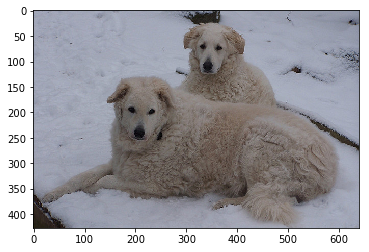

In [44]:
## check out if arbitrary pic is recognized

img = cv2.imread(dog_files_short[0])
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [48]:
Xception_predict_breed(train_files[0])
## Looks as right as an average person could predict

'Kuvasz'

In [49]:
dog_names[np.argmax(train_targets[0])] 

'Kuvasz'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

In [100]:
def predict_image(imagePath):
    ## accepts a filepath as argument and returns prediction of breed for dogs or similarity to breed for people
    try:
        ## check with the more accurate model (the human-finder) first
        if any(facefinder.predict_classes([graySquare(imagePath, 250)])):
            return compare_person(imagePath)
        ## then check for dogs if no people
        elif dog_detector(imagePath):
            return predict_breed(imagePath)
        ## then report failure to find canine or human in photo
        else:
            return no_dice(imagePath)
    except:
        print('Trouble loading any image from the file provided--Please try another file')
        

In [54]:
def compare_person(img_path):
    print('They say dogs and owners grow to resemble each other.')
    show_pic(img_path)
    print('It seems this person owns a ...')
    print(breed_of(img_path))

In [55]:
def predict_breed(img_path):
    print('WOOF!')
    show_pic(img_path)
    print('Looks like a ...')
    print(breed_of(img_path))

In [56]:
def show_pic(img_path):
# display the image with cv2 and pyplot
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [57]:
def breed_of(img_path):
    ## use the Xception model from Step 5 above
    return Xception_predict_breed(img_path)

In [58]:
def no_dice(img_path):
    print('Can you find a dog or a person in this photo?')
    show_pic(img_path)
    print('If so, you are proof that humans are smarter than computers (though not necessarily dogs).')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ Worse! The most annoying part is that it doesn't recognize humans anywhere near as well as it did with the test humans (human_short_list).  I would definitely retrain it on thousands of random and augmented photos of people in various sizes, settings, scales, zooms, etc., for a more generalized network than was learned from the LFW set.  Alternatively, I could write code to locate the bounding box for the face, crop it just outside of that, and only then resize it to 250x250. As far as the dog breeds, The first two breeds I happened to test on (miniature goldendoodle and samoyed) weren't even in the dog dictionary, but the model did find suitable guesses for each, more or less.  Definitely we need more variety of breeds to make this app somewhat accurate.  I'm also wondering if there is a way to rescale better to keep the original proportions of a dog more intact.  So many of these dogs differ only slightly in their proportions, at least in the pictures we trained on, that I don't see how a computer can accurately cope with the stretching and compacting that happens with resizing/rescaling to feed into keras. I tried to augment the photos to feed 20,000 of them into VGG-19 for potentially better bottleneck features, but my Jupyter notebook ran out of memory.  I have to think there is a lot of room for improvement with augmenting.

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [136]:
dog_names

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

1/1 [==============================] - 0s
WOOF!


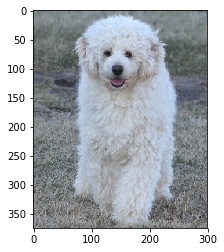

Looks like a ...
Bichon_frise


In [116]:
## This is a miniature goldendoodle-- That's not even in the dog breed dict.  But Bichon frisee is somewhat similar
predict_image('images/Chance-a.jpg')

In [117]:
# Another mini goldendoodle-- portuguese water dogs are maybe somewhat similar but black
predict_image('images/Deni.jpg')

1/1 [==============================] - 0s
WOOF!


Looks like a ...
Portuguese_water_dog


1/1 [==============================] - 0s
WOOF!


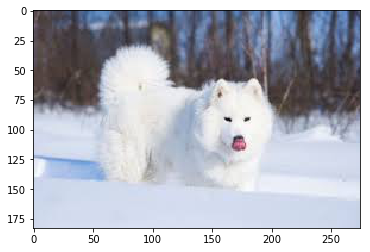

Looks like a ...
American_eskimo_dog


In [118]:
## A samoyed in white-- similar to american eskimo dog but not the same
predict_image('images/images (1).jpg')

1/1 [==============================] - 0s
They say dogs and owners grow to resemble each other.


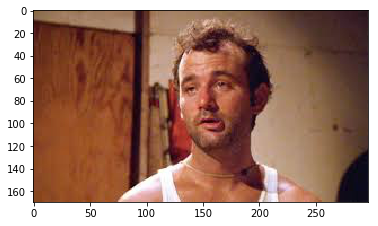

It seems this person owns a ...
Bichon_frise


In [119]:
## Carl Spagler at home.  Maybe bichon frises are varmint hunters too?
predict_image('images/images (2).jpg')

In [120]:
predict_image('images/images (3).jpg')

1/1 [==============================] - 0s
Can you find a dog or a person in this photo?


If so, you are proof that humans are smarter than computers (though not necessarily dogs).


1/1 [==============================] - 0s
WOOF!


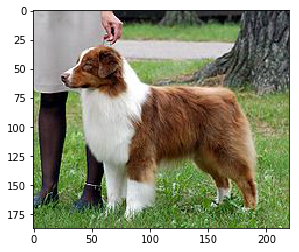

Looks like a ...
Australian_shepherd


In [137]:
# Australian shepherd dog
predict_image('images/220px-Redtriaussie01.jpg')

In [122]:
## Algo can't recognize this because of resizing 
predict_image('images/Photo on 7-6-17 at 1.03 PM #2.jpg')

1/1 [==============================] - 0s
Can you find a dog or a person in this photo?


If so, you are proof that humans are smarter than computers (though not necessarily dogs).


In [180]:
# pre-fab algo fails too
face_detector('images/Photo on 7-6-17 at 1.03 PM #2.jpg')

False

1/1 [==============================] - 0s
Can you find a dog or a person in this photo?


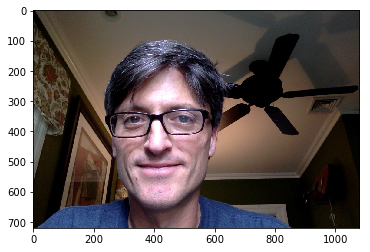

If so, you are proof that humans are smarter than computers (though not necessarily dogs).


In [123]:
# Algorithm can't recognize because of resizing and maybe confusing background
predict_image('images/Photo on 7-6-17 at 2.30 PM #2.jpg')

In [128]:
# This is what the algorithm is failing to recognize as containing a human

gray = cv2.imread('images/Photo on 7-6-17 at 2.30 PM #2.jpg', 0)
gray = cv2.resize(gray, (250,250))

plt.imshow(gray)
plt.show()

1/1 [==============================] - 0s
They say dogs and owners grow to resemble each other.


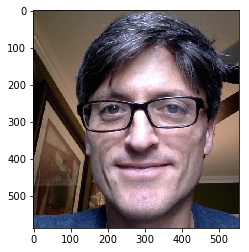

It seems this person owns a ...
Dachshund


In [131]:
# This is after cropping the image as more squarish and tighter around the face
predict_image('images/Photo on 7-6-17 at 2.30 PM #2 (1).jpg')

In [132]:
# And it recognizes this one now too, after cropping it down to squarish around the face
##  Note that it predicts different breed since the face is now turned
predict_image('images/Photo on 7-6-17 at 1.03 PM #2 (1).jpg')

1/1 [==============================] - 0s
They say dogs and owners grow to resemble each other.


It seems this person owns a ...
Chinese_crested


1/1 [==============================] - 0s
They say dogs and owners grow to resemble each other.


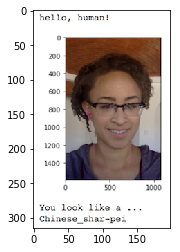

It seems this person owns a ...
Cane_corso


In [130]:
predict_image('images/sample_human_output.png')

### =======================================================================================
Below is a failed attempt to augment photos, pass them through VGG-19 to create bottleneck features, and then train a fully-connected network on top of that.  Accuracy dropped from 76% to 71%, so more augmented photos were generated, at which point the notebook ran out of memory.
## (Saving this for future reference though)

## Try augmenting then feeding into VGG19

In [183]:
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

batch_size = 32

# create and configure augmented image generator
datagen = ImageDataGenerator(
    rotation_range=45,  # randomly rotate images up to 45 degrees
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

In [184]:
## Lots of help from this:  https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
VGG19mod = applications.VGG19(include_top=False, weights='imagenet')

In [185]:
# create and save the bottleneck features for the augmented training photos
trainGen = datagen.flow(train_tensors, train_targets, batch_size=batch_size)
# feed one pic thru to test structure
aug_bottleneck_train_one = VGG19mod.predict_generator(trainGen, steps=1)
np.save('aug_bottleneck_features_train_one.npy', aug_bottleneck_train_one)

In [186]:
tG = trainGen.next()  # inspect a generated batch

print(tG[0].shape, tG[1].shape)


(32, 224, 224, 3) (32, 133)


In [187]:
aug_bottleneck_train_one.shape

(32, 7, 7, 512)

In [191]:
##  manually pack generated photos into an ordered list, along with their matching targets
pics = []
breeds = []
for batch in range(10000 // batch_size):
    aug_pics = trainGen.next()
    for pic in aug_pics[0]:
        pics.append(pic)
    for breed in aug_pics[1]:
        breeds.append(breed)
    

In [192]:
len(pics)

9976

In [194]:
## create and save the bottleneck features for the augmented validation photos
validGen = datagen.flow(valid_tensors, valid_targets, batch_size=batch_size)


In [195]:
##  manually pack generated photos into an ordered list, along with their matching targets
val_pics = []
val_breeds = []
for batch in range(2000 // batch_size):
    val_pics_batch = validGen.next()
    for pic in val_pics_batch[0]:
        val_pics.append(pic)
    for val_breed in val_pics_batch[1]:
        val_breeds.append(val_breed)
    

In [198]:
pics = np.array(pics)

In [199]:
pics.shape

(9976, 224, 224, 3)

In [201]:
## takes a long time on laptop CPU
aug_bottlefeat_train = VGG19mod.predict(pics)
np.save('aug_bottlefeat_train.npy', aug_bottlefeat_train)

In [ ]:
## takes a long time on laptop CPU
val_pics = np.array(val_pics)
aug_bottlefeat_valid = VGG19mod.predict(val_pics)
np.save('aug_bottlefeat_valid.npy', aug_bottlefeat_valid)

In [189]:
# Model architecture

VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dropout(0.3))
VGG19_model.add(Dense(256, activation='relu'))
VGG19_model.add(Dropout(0.4))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 133)               34181     
Total params: 165,509
Trainable params: 165,509
Non-trainable params: 0
_________________________________________________________________


In [39]:
## compile the model
VGG19_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='aug_VGG19.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
VGG19_model.fit(aug_bottlefeat_train, np.array(breeds), 
          validation_data=(aug_bottlefeat_valid, np.array(val_breeds)),
          epochs=30, batch_size=32, callbacks=[checkpointer], verbose=1)


In [ ]:
# use pre-run test_VGG19 and test_targets to test
# get index of predicted dog breed for each image in test set
aug_VGG19_preds = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(aug_VGG19_preds)==np.argmax(test_targets, axis=1))/len(aug_VGG19_preds)
print('Test accuracy: %.4f%%' % test_accuracy)